In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [2]:
# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = torch.device(device)
device

cuda


device(type='cuda')

In [3]:
smifile = "250k_rndm_zinc_drugs_clean_3.csv"
data = pd.read_csv(smifile, delimiter = ",")

In [5]:
data.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

In [7]:
fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(data["smiles"][0]), 2, nBits=2048)

In [8]:
# fp to numpy array
arr = np.zeros((1,))
DataStructs.ConvertToNumpyArray(fp, arr)
arr

array([0., 0., 0., ..., 0., 0., 0.])

In [9]:
np.where(arr == 1)

(array([  33,   41,   80,  114,  118,  141,  255,  325,  384,  392,  465,
         650,  655,  656,  699,  807,  843,  862,  875, 1032, 1057, 1088,
        1152, 1199, 1211, 1224, 1233, 1339, 1349, 1357, 1380, 1417, 1580,
        1665, 1685, 1696, 1750, 1756, 1808, 1810, 1816, 1840, 1873, 1917,
        1928, 1948]),)

In [10]:
def get_fingerprint(smiles):
    fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=2048)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [11]:
# import counter
from collections import Counter, defaultdict
bits_count = Counter()
for smiles in data["smiles"]:
    fp = get_fingerprint(smiles)
    non_zero = np.where(fp == 1)[0]
    bits_count.update(non_zero)

In [12]:
# sort by id
len(bits_count)

2048

In [13]:
#least common
bits_count.most_common()[-100:]

[(1735, 746),
 (995, 745),
 (513, 745),
 (691, 742),
 (1933, 741),
 (86, 739),
 (712, 739),
 (1716, 735),
 (761, 734),
 (367, 732),
 (435, 732),
 (2015, 721),
 (1044, 719),
 (633, 717),
 (1566, 716),
 (1378, 713),
 (1165, 711),
 (709, 711),
 (1094, 708),
 (331, 706),
 (903, 706),
 (1913, 703),
 (174, 701),
 (1316, 700),
 (1844, 698),
 (1901, 698),
 (1315, 698),
 (572, 697),
 (1271, 688),
 (1674, 688),
 (1838, 686),
 (874, 683),
 (1194, 683),
 (1947, 680),
 (124, 678),
 (340, 667),
 (1335, 665),
 (639, 662),
 (336, 657),
 (2005, 654),
 (439, 650),
 (1981, 646),
 (1748, 644),
 (1737, 643),
 (1558, 638),
 (905, 637),
 (1113, 636),
 (1098, 628),
 (96, 627),
 (1493, 627),
 (644, 625),
 (928, 622),
 (183, 620),
 (669, 616),
 (981, 614),
 (137, 613),
 (1116, 612),
 (566, 593),
 (1421, 593),
 (1037, 590),
 (578, 584),
 (1787, 578),
 (1672, 574),
 (851, 574),
 (1789, 570),
 (414, 569),
 (1857, 565),
 (47, 564),
 (889, 559),
 (416, 550),
 (1902, 550),
 (1772, 542),
 (792, 538),
 (1874, 531),
 (6

In [14]:
class SmilesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.smiles = data["smiles"]
    def __len__(self):
        return len(self.smiles)
    def __getitem__(self, idx):
        tensor = torch.from_numpy(get_fingerprint(self.smiles[idx])).float()
        return tensor

In [15]:
dataset = SmilesDataset(data)
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = int(len(dataset) - train_size - valid_size)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [17]:
for batch in train_loader:
    print(batch.shape)
    break

torch.Size([64, 2048])


In [18]:
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, latent_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        x = self.fc4(x)
        return x
class Decoder(nn.Module):
    def __init__(self, latent_size, output_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, output_size)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, with_sigmoid=True):
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        if with_sigmoid:
            x = self.sigmoid(self.fc4(x))
        else:
            x = self.fc4(x)
        return x

In [19]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size, dropout=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size, latent_size, dropout)
        self.decoder = Decoder(latent_size, input_size, dropout)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
model = Autoencoder(2048, 256, dropout=0.0).to(device)
history = {
    "train_loss": [],
    "valid_loss": []
}

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
model_name = "fp_autoencoder_drop_0%_2048_256_zinc250k.pt"

In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [24]:
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
    print("Model loaded")
else:
    print("Model not found")

Model not found


In [63]:
from datetime import datetime

epochs = 20
if len(history['valid_loss']) > 0:
    min_val_loss = min(history['valid_loss'])
else:
    min_val_loss = np.inf
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch.size(0)
    train_loss = train_loss/len(train_loader)
    history["train_loss"].append(train_loss)
    model.eval()
    for batch in valid_loader:
        batch = batch.to(device)
        output = model(batch)
        loss = criterion(output, batch)
        valid_loss += loss.item()*batch.size(0)
    valid_loss = valid_loss/len(valid_loader)
    if valid_loss < min_val_loss:
        torch.save(model.state_dict(), model_name)
        print("Model saved")
        min_val_loss = valid_loss
    history["valid_loss"].append(valid_loss)
    scheduler.step(valid_loss)
    time = datetime.now().strftime(format="%H:%M:%S")
    print(f"Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}, Current time: {time}" )

Epoch: 1 	Training Loss: 0.969416 	Validation Loss: 1.729768, Current time: 11:36:38
Epoch: 2 	Training Loss: 0.957676 	Validation Loss: 1.730115, Current time: 11:37:38
Epoch 00033: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 3 	Training Loss: 0.947173 	Validation Loss: 1.733609, Current time: 11:38:41
Model saved
Epoch: 4 	Training Loss: 0.728388 	Validation Loss: 1.672177, Current time: 11:39:44
Epoch: 5 	Training Loss: 0.673887 	Validation Loss: 1.710386, Current time: 11:40:45
Epoch: 6 	Training Loss: 0.647942 	Validation Loss: 1.742887, Current time: 11:41:47
Epoch: 7 	Training Loss: 0.629791 	Validation Loss: 1.777149, Current time: 11:42:48
Epoch 00038: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 8 	Training Loss: 0.615562 	Validation Loss: 1.806433, Current time: 11:43:49
Epoch: 9 	Training Loss: 0.581224 	Validation Loss: 1.823931, Current time: 11:44:49
Epoch: 10 	Training Loss: 0.577971 	Validation Loss: 1.831469, Current time: 11:45:51


KeyboardInterrupt: 

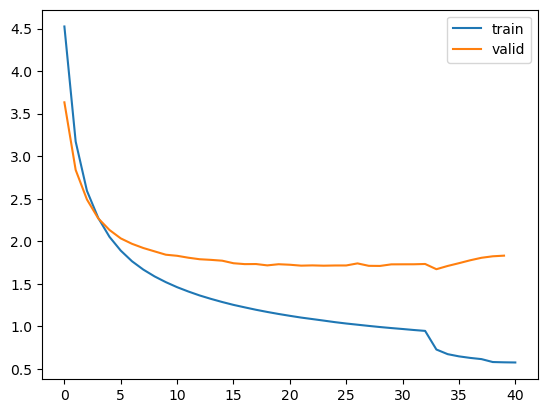

In [64]:
plt.plot(history["train_loss"], label="train")
plt.plot(history["valid_loss"], label="valid")
plt.legend()
plt.show()

In [65]:
diffs = []
total = 0
def compare_fps(fp1, fp2):
    # check which percent of ones from fp1 are in fp2
    fp1 = fp1.astype(int)
    fp2 = fp2.astype(int)
    fp1_idx = np.where(fp1 == 1)[0]
    fp2_idx = np.where(fp2 == 1)[0]
    return len(np.intersect1d(fp1_idx, fp2_idx))/len(fp1_idx)
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        output = model(batch)
        output = output > 0.5
        total += len(batch)
        for i in range(len(output)):
            batch_int = batch[i].cpu().detach().numpy().astype(int)
            output_int = output[i].cpu().detach().numpy().astype(int)
            out_idx = np.where(output_int == 1)[0]
            batch_idx = np.where(batch_int == 1)[0]
            # check how many elements from batch are in output
            diff = len(np.intersect1d(batch_idx, out_idx))
            # print(f'Batch: {batch_idx}')
            # print(f'Output: {out_idx}')
            # print(f'Diff: {diff / len(batch_idx)}')
            diffs.append(diff / len(batch_idx))

In [66]:
print(f"Accuracy: {np.mean(diffs):.5f}")

Accuracy: 0.79686


In [67]:
def get_models(model_name):
    model = Autoencoder(2048, 256).to(device)
    model.load_state_dict(torch.load(model_name))
    return model.encoder, model.decoder

In [68]:
encoder, decoder = get_models(model_name)
encoder.eval()
decoder.eval()

Decoder(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [69]:
mdma = 'CC(NC)CC1=CC=C(OCO2)C2=C1'
mdma = get_fingerprint(mdma)
mdma = torch.from_numpy(mdma).float().to(device)
mdma = mdma.unsqueeze(0)

In [70]:
encoded = encoder(mdma)
encoded_bits = encoded.cpu().detach().numpy()
encoded

tensor([[ 1.0870e+00,  5.5311e-01, -1.2181e-01,  1.7645e-02,  7.0442e-02,
          6.8761e-02,  7.8911e-01,  1.0802e-01, -8.0437e-02,  2.7077e-01,
         -3.7602e-02, -6.3705e-02, -5.4136e-02, -4.9423e-01,  2.8206e-02,
          3.2241e-02,  6.0992e-03, -1.5009e-02,  2.0817e-02,  1.2166e-02,
         -4.3379e-02,  1.3367e-02, -7.6961e-02,  1.9422e-02, -6.1103e-02,
          1.3652e-03,  9.5217e-02, -6.2457e-01, -6.5403e-02,  1.2732e-01,
          6.6739e-02,  1.4372e-01,  1.8945e-02, -1.9626e-02, -4.2419e-02,
         -3.8371e-02,  1.8034e-02, -6.7863e-02,  1.1769e-01,  2.5034e-03,
         -4.4857e-03,  9.5177e-01, -2.7372e-02,  1.0361e-02, -7.7103e-02,
          2.0386e-02, -1.9446e-01, -3.1254e-01,  1.3667e-02, -9.1747e-03,
          7.7060e-02,  5.8381e-02,  4.1579e-02, -7.2794e-02, -6.6289e-01,
         -1.0876e+00,  5.4006e-02,  5.7426e-02,  2.4745e-01,  7.5138e-02,
          7.9019e-01, -4.6240e-03,  4.3072e-02,  2.3322e-03, -1.3085e-02,
         -2.7702e-02,  8.1273e-02, -7.

In [78]:
decoded = decoder(encoded)
decoded = decoded.cpu().detach().numpy()
decoded = decoded > 0.5
decoded = decoded.astype(int)
decoded_idx = (np.where(decoded == 1))[1]
decoded_idx

array([   1,   79,   80,  257,  283,  310,  441,  656,  690,  738,  857,
        875,  926,  937, 1035, 1057, 1152, 1349, 1380, 1430, 1514, 1647,
       1750, 1754, 1800, 1863, 1873, 1905, 2018, 2031])

In [80]:
original_fp = np.where(get_fingerprint('CC(NC)CC1=CC=C(OCO2)C2=C1') == 1)[0]

array([   1,   79,   80,  177,  283,  310,  441,  656,  738,  875,  926,
       1035, 1057, 1152, 1349, 1380, 1430, 1514, 1647, 1728, 1750, 1754,
       1800, 1863, 1873, 1905, 1907, 1990, 2018, 2031])

In [86]:
import pubchempy as pcp
# get all amino acids
names = ['Alanine', 'Arginine', 'Asparagine', 'Aspartic acid', 'Cysteine', 'Glutamic acid', 'Glutamine', 'Glycine', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Proline', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine']
aa_smiles = []
for name in names:
    aa = pcp.get_compounds(name, 'name')
    aa_smiles.append(aa[0].canonical_smiles)

In [87]:
aa_fps = [get_fingerprint(smile) for smile in aa_smiles]

In [88]:
encoded = encoder(torch.from_numpy(np.array(aa_fps)).float().to(device))

In [89]:
encoded = encoded.cpu().detach().numpy()

In [90]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(encoded)

PCA(n_components=2)

In [91]:
vec_pca = pca.transform(encoded)

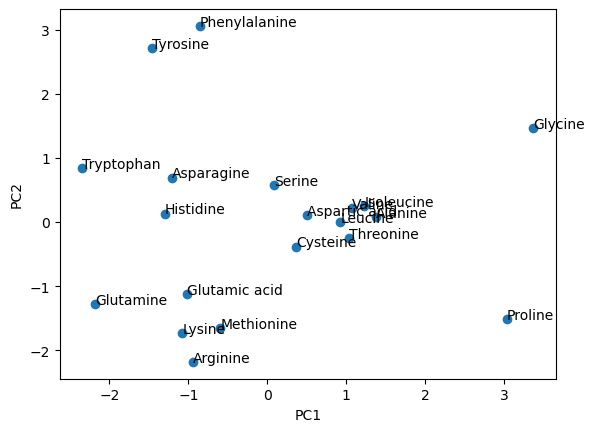

In [92]:
plt.scatter(vec_pca[:,0], vec_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
for i, txt in enumerate(names):
    plt.annotate(txt, (vec_pca[i,0], vec_pca[i,1]))

In [93]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=5)

In [94]:
tsne_componets = tsne.fit_transform(encoded)

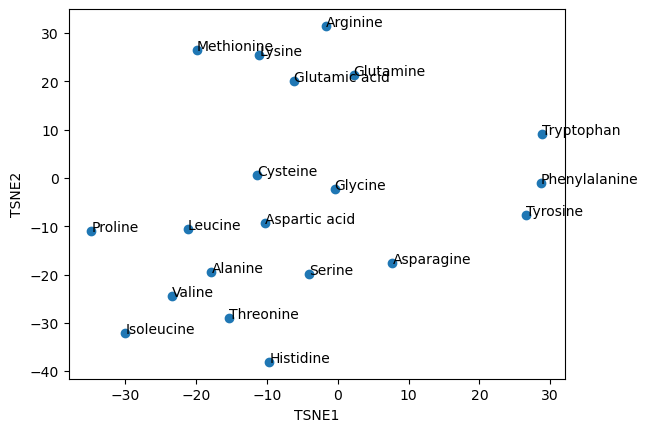

In [95]:
plt.scatter(tsne_componets[:,0], tsne_componets[:,1])
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
for i, txt in enumerate(names):
    plt.annotate(txt, (tsne_componets[i,0], tsne_componets[i,1]))

In [96]:
aa_map = {name:smile for name, smile in zip(names, aa_smiles)}

In [97]:
aa_map['Leucine']

'CC(C)CC(C(=O)O)N'

In [98]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
def tanimoto_similarity(smiles1, smiles2):
    '''
    Returns the Tanimoto similarity between two SMILES strings
    '''
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    return DataStructs.FingerprintSimilarity(fp1, fp2)

In [99]:
tanimoto_similarity(aa_map['Leucine'], aa_map['Isoleucine'])

0.4230769230769231

In [100]:
encoded_leucine = encoder(torch.from_numpy(np.array([get_fingerprint(aa_map['Leucine'])])).float().to(device))
encoded_leucine = encoded_leucine.cpu().detach().numpy()[0]
encoded_isoleucine = encoder(torch.from_numpy(np.array([get_fingerprint(aa_map['Isoleucine'])])).float().to(device))
encoded_isoleucine = encoded_isoleucine.cpu().detach().numpy()[0]

In [101]:
from scipy.spatial.distance import cosine, euclidean

In [102]:
print(f'Tanimoto distance: {tanimoto_similarity(aa_map["Leucine"], aa_map["Isoleucine"])}')
print(f'Cosine distance: {cosine(encoded_leucine, encoded_isoleucine)}')
print(f'Euclidean distance: {euclidean(encoded_leucine, encoded_isoleucine)}')

Tanimoto distance: 0.4230769230769231
Cosine distance: 0.30146539211273193
Euclidean distance: 4.219049453735352


In [103]:
results = {'Name':[], 'Tanimoto':[], 'Cosine':[], 'Euclidean':[]}
for name, smile in aa_map.items():
    encoded = encoder(torch.from_numpy(np.array([get_fingerprint(smile)])).float().to(device))
    encoded = encoded.cpu().detach().numpy()[0]
    results['Name'].append(name)
    results['Tanimoto'].append(tanimoto_similarity(aa_map['Leucine'], smile))
    results['Cosine'].append(1 - cosine(encoded_leucine, encoded))
    results['Euclidean'].append(euclidean(encoded_leucine, encoded))
df = pd.DataFrame(results).sort_values(by='Tanimoto', ascending=False)

In [104]:
df

,Name,Tanimoto,Cosine,Euclidean
10,Leucine,1.000000,1.000000,0.000000
3,Aspartic acid,0.545455,0.811671,3.132615
2,Asparagine,0.521739,0.707713,5.047590
15,Serine,0.500000,0.813986,3.635709
0,Alanine,0.500000,0.839189,2.843140
4,Cysteine,0.478261,0.759074,3.542818
12,Methionine,0.444444,0.568178,4.727741
5,Glutamic acid,0.440000,0.684542,4.168347
19,Valine,0.434783,0.743802,3.797592
6,Glutamine,0.423077,0.679096,4.944146


In [105]:
no_target = df[df['Name'] != 'Leucine']
print(f'Most similar in Tanimoto: {no_target.sort_values(by="Tanimoto", ascending=False).iloc[0,0]}')
print(f'Most similar in Cosine: {no_target.sort_values(by="Cosine", ascending=False).iloc[0,0]}')
print(f'Most similar in Euclidean: {no_target.sort_values(by="Euclidean", ascending=True).iloc[0,0]}')

Most similar in Tanimoto: Aspartic acid
Most similar in Cosine: Alanine
Most similar in Euclidean: Alanine


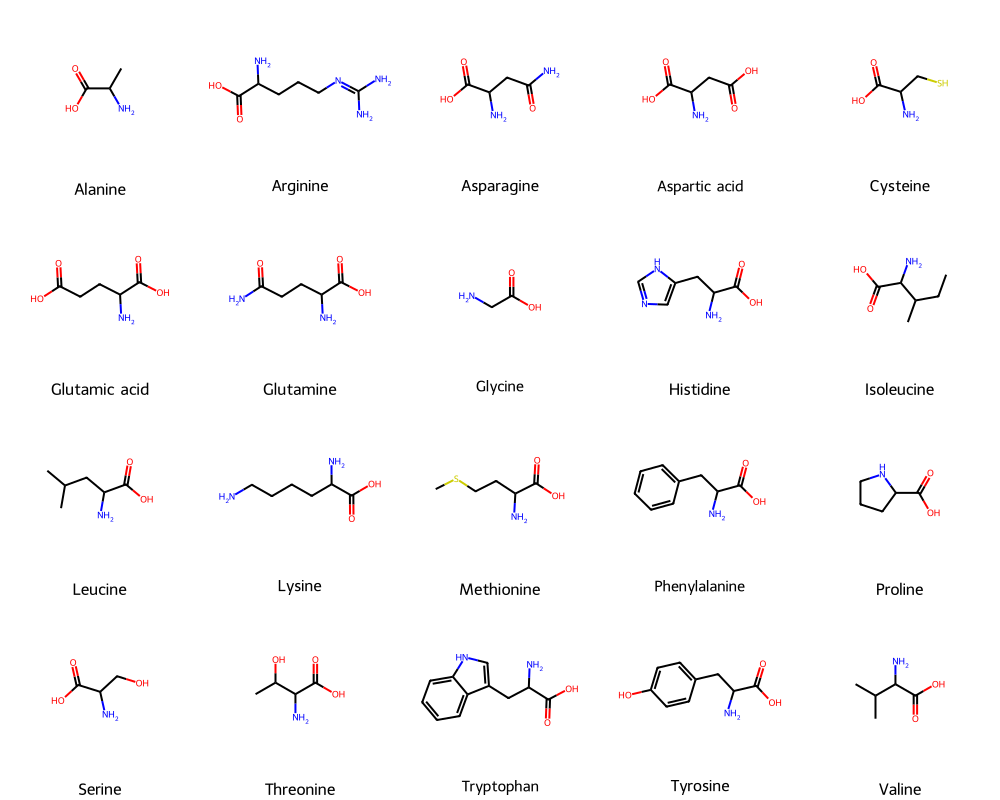

In [106]:
from rdkit.Chem import Draw
# draw all amino acids
mols = [Chem.MolFromSmiles(smile) for smile in aa_smiles]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=names)

In [107]:
# get substructure matches
from rdkit.Chem import rdFMCS
leucine = Chem.MolFromSmiles(aa_map['Leucine'])
glu = Chem.MolFromSmiles(aa_map['Glutamic acid'])
aspartic_acid = Chem.MolFromSmiles(aa_map['Aspartic acid'])
mcs = rdFMCS.FindMCS([leucine, glu, aspartic_acid], ringMatchesRingOnly=True, completeRingsOnly=True)
mcs = Chem.MolFromSmarts(mcs.smartsString)

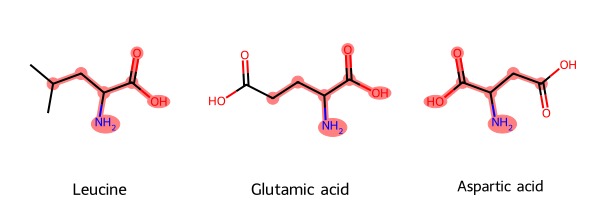

In [108]:
# draw substructure matches
Draw.MolsToGridImage([leucine, glu, aspartic_acid], molsPerRow=3, subImgSize=(200,200), highlightAtomLists=[leucine.GetSubstructMatch(mcs), glu.GetSubstructMatch(mcs), aspartic_acid.GetSubstructMatch(mcs)], legends=['Leucine', 'Glutamic acid', 'Aspartic acid'])